<a href="https://colab.research.google.com/github/MosaicGroupCMU/African-MRS-Tutorials/blob/main/Google-Colab/Quantum_Espresso_Mechanical_Properties_true.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating Mechanical Properties in QuantumESPRESSO

In this Google Colab workbook, we will use QuantumESPRESSO to calculate and visualise the electronic band structure of silicon. As always, there will be an [easy](https://github.com/MosaicGroupCMU/African-MRS-Tutorials/blob/4dc8b2cd702c39bd1b037300cae69a3b335cb526/Google-Colab/QE_Silicon_Electron_Bands_Easy.ipynb), medium, and hard version of this workbook.

Prerequisite: `Quantum_Espresso_Silicon.ipynb`

Contributors: [Seda Oturak](https://github.com/sedaoturak), [Ismaila Dabo](https://scholar.google.com/citations?user=rN299m0AAAAJ&hl=en),
 [Simon Gelin](https://scholar.google.com/citations?user=d1BSrxoAAAAJ&hl=en), [Jessica Wen](https://github.com/JessicaWen-PhD), [Cierra Chandler](https://github.com/Cierra-Chandler), [Henry Eya](https://github.com/Henrynweya)

# Install libraries, environment, and Quantum ESPRESSO

This part installs libraries for numerical calculations and plotting.

In [1]:
# load plotting libraries
import matplotlib.pyplot as plt

# load numerical libraries
import numpy as np

Quantum ESPRESSO is a plane wave code, which uses Fourier transforms to solve equations in plane wave space. This part installs libraries for fast Fourier transforms (FFTs).

In [2]:
# eliminate text output during installation
%%capture

# install mathematical libraries to peform fast Fourier transforms
# (the exclamation mark means that the command is run under Linux)
! apt-get install -y libfftw3-3 libfftw3-dev libfftw3-doc

The Atomic Simulation Environment (ASE) is a set of tools for running, visualizing, and analyzing simulations. This part installs ASE.

In [3]:
# eliminate text output during installation
%%capture

# install the Atomic simulation environment
# ! apt install ase
! pip install git+https://gitlab.com/ase/ase

Compiling Quantum ESPRESSO from scratch would take a long time. This part uploads pre-compiled executable files (`.x` extension) and additional files containing the pseudopotentials.

In [4]:
# eliminate text output during installation
%%capture
!pip install gdown

# navigate to main directory named '/content/'
%cd /content/

# download the pre-compiled files in compressed format (under Linux)
#! wget 'https://docs.google.com/uc?export=download&id=1kw_CJMjP6ggDZXDNp5phAqCPpoe2WXCA' -O qe-lite.tgz
!gdown 'https://drive.google.com/uc?export=download&id=13l-Kiyg-F6aYb5lF8M3RsE1hSnLRdGna' -O qe-lite.tgz


# unpack the compressed files (under Linux)
!tar -xvf qe-lite.tgz

# clean up some files
! rm -rf sample_data qe-lite.tgz

# Prepare Quantum ESPRESSO input file

The type of calculation we will be using is a variable-cell
 relaxation also known as **vc-relax**. This type of calculation allows both the atoms and the lattice parameters shift to find the optimal state, while a **relax** calculation only allows for the atomic coordinates.  

We will be using the unit cell of diamond silicon.


The definition of the input parameters of the `pw.x` executable can be found at `www.quantum-espresso.org/Doc/INPUT_PW.html`.

In [13]:
# create calculation folder and navigate into it
%mkdir -p /content/aluminum
%cd /content/aluminum/

# create input and write it into the file si.scf.in
qe_input = """
&control
  prefix='aluminum',
  calculation='vc-relax',
  tstress = .true., ! stress tensor
  tprnfor = .true., ! print forces
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/aluminum/'
/
&system
  ibrav = 0,
  celldm(1) = 4.05,
  nat = 1,
  ntyp = 1,
  ecutwfc = 50.0,
  ecutrho = 400.0,
  occupations = 'smearing',          !metallic system
  smearing = 'cold',                  !metallic system
  degauss = 0.01,
/
&electrons
  conv_thr = 1e-8,
/
&ions
  ion_dynamics = 'bfgs' !
/
&cell
  cell_dynamics = 'bfgs',
  press = 0.001,
  press_conv_thr = 0.5
/
ATOMIC_SPECIES
Al  26.9815385  Al.UPF

ATOMIC_POSITIONS (angstrom)
Al 0.00 0.00 0.00

K_POINTS automatic
   4 4 4 0 0 0
CELL_PARAMETERS (alat)
 1.0  0.00  0.00
 0.00  1.0  0.00
 0.00  0.00  1.0
"""


with open("al.vc-relax.in", "w") as f:
    f.write(qe_input)

# print the content of the input file (under Linux)
! cat al.vc-relax.in

/content/aluminum

&control
  prefix='aluminum',
  calculation='vc-relax',
  tstress = .true., ! stress tensor
  tprnfor = .true., ! print forces
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/aluminum/'
/
&system
  ibrav = 0,
  celldm(1) = 4.05,
  nat = 1,
  ntyp = 1,
  ecutwfc = 50.0,
  ecutrho = 400.0,
  occupations = 'smearing',          !metallic system
  smearing = 'cold',                  !metallic system
  degauss = 0.01,
/
&electrons
  conv_thr = 1e-8,
/
&ions
  ion_dynamics = 'bfgs' !
/
&cell
  cell_dynamics = 'bfgs',
  press = 0.001,
  press_conv_thr = 0.5
/
ATOMIC_SPECIES
Al  26.9815385  Al.UPF

ATOMIC_POSITIONS (angstrom)
Al 0.00 0.00 0.00

K_POINTS automatic
   4 4 4 0 0 0
CELL_PARAMETERS (alat)
 1.0  0.00  0.00
 0.00  1.0  0.00
 0.00  0.00  1.0


Notice that we add additional cards/sections to our input file. Since we are optimizing the positions and lattice parameters, we need to enable the:


*   Ions card (for optimizing the atomic positions)
*   Cell card (for optimizing the cell parameters)

In the Cell card, we can set the target pressure of the cell as well as the pressure convergence threshold.


In [14]:
import ase.io.espresso
from ase import Atoms
from ase.visualize import view
from ase.build import make_supercell
from ase.build import bulk

# extract unit cell information from input file using ASE
input_file = ase.io.espresso.read_espresso_in('al.vc-relax.in')
al = Atoms(input_file)

# create a supercell (3 × 3 × 3) using ASE
multiplier = np.identity(3) * 1
al_supercell = make_supercell(al,multiplier)

# visualize the supercell
view(al_supercell, viewer='x3d')

# Lattice parameter

#Structure Optimizaton

# Stress-Strain Behaviour

In this section, we will


In [15]:
import re

# create a list for cell dimensions to be tested
lattice_constants = np.arange(9.5,11.1,0.1)

# find the "lattice constant" line in the input file
lat_cons_index = qe_input.find('celldm(1) =') + 11

total_energies = []
total_strain = []
total_stress = []

for constant in lattice_constants:
  # update the input file with the new lattice constant
  new_input_file = qe_input[:lat_cons_index] + " %.2f" % constant + qe_input[lat_cons_index+5:]

  # overwrite the input file
  with open("al.vc-relax.in", "w") as f:
    f.write(new_input_file)

  ! cat al.vc-relax.in
  ! /content/qe-lite/bin/pw.x  -in al.vc-relax.in > al.vc-relax.out # run the DFT input file

  output = ase.io.read("/content/aluminum/al.vc-relax.out") # read the output file

  total_energies.append(output.get_total_energy()) # record the calculated total energy

  #Calculate the strain from the output
  input = ase.io.read("/content/aluminum/al.vc-relax.in")

  lattice_initial = input.cell.cellpar()[0] # initial lattice parameters
  lattice_final = output.cell.cellpar()[0] # final lattice parameters

  total_strain.append((lattice_final - lattice_initial)/lattice_initial)

  #Get the strain from the output file

  file_path = "/content/aluminum/al.vc-relax.out"

  # Open the file and read content
  with open(file_path, 'r') as file:
        content = file.read()

    # Regular expression to match the total stress matrix block
  stress_pattern = r"total\s+stress\s+\(Ry/bohr\*\*3\)\s+\(kbar\)[\s\S]+?(-?\d+\.\d+)\s+(-?\d+\.\d+)\s+(-?\d+\.\d+)"

    # Search for the total stress matrix
  matches = re.findall(stress_pattern, content)

  if matches:
        last_match = matches[-1]  # Get the last match (total stress matrix)

        # Extract the diagonal stress values from the last match
        stress_diagonal = float(last_match[1])

        total_stress.append(stress_diagonal)



&control
  prefix='aluminum',
  calculation='vc-relax',
  tstress = .true., ! stress tensor
  tprnfor = .true., ! print forces
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/aluminum/'
/
&system
  ibrav = 0,
  celldm(1) = 9.50,
  nat = 1,
  ntyp = 1,
  ecutwfc = 50.0,
  ecutrho = 400.0,
  occupations = 'smearing',          !metallic system
  smearing = 'cold',                  !metallic system
  degauss = 0.01,
/
&electrons
  conv_thr = 1e-8,
/
&ions
  ion_dynamics = 'bfgs' !
/
&cell
  cell_dynamics = 'bfgs',
  press = 0.001,
  press_conv_thr = 0.5
/
ATOMIC_SPECIES
Al  26.9815385  Al.UPF

ATOMIC_POSITIONS (angstrom)
Al 0.00 0.00 0.00

K_POINTS automatic
   4 4 4 0 0 0
CELL_PARAMETERS (alat)
 1.0  0.00  0.00
 0.00  1.0  0.00
 0.00  0.00  1.0
^C


StopIteration: 

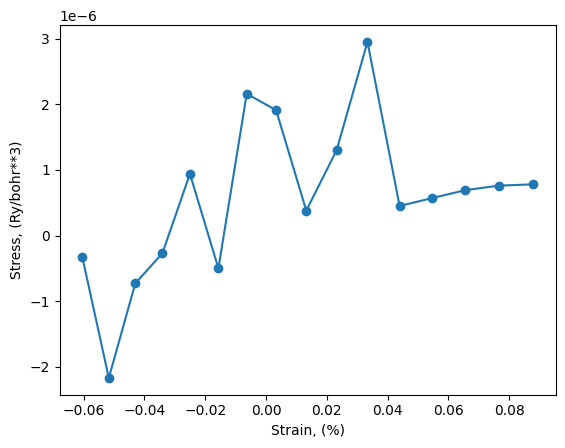

In [ ]:
# plot potential energy curve

from scipy.signal import savgol_filter

#smoothed_stresses = savgol_filter(total_stress, window_length=12, polyorder=2)

fig,ax = plt.subplots()
#ax.plot(total_strain, smoothed_stresses,'o-')
ax.plot(total_strain, total_stress,'o-')
ax.set_xlabel('Strain, (%)')
ax.set_ylabel('Stress, (Ry/bohr**3)')
plt.show()

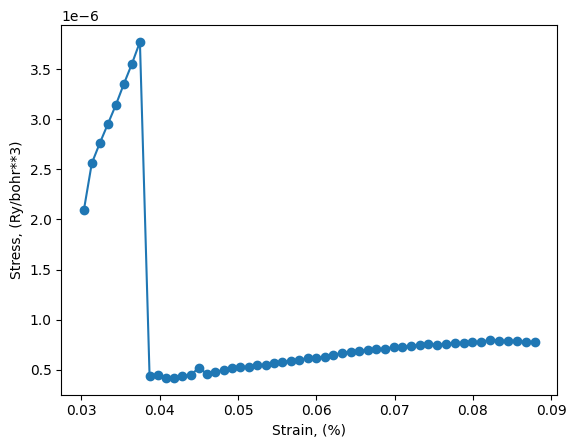

In [ ]:
# plot potential energy curve

from scipy.signal import savgol_filter

#smoothed_stresses = savgol_filter(total_stress, window_length=12, polyorder=2)

fig,ax = plt.subplots()
#ax.plot(total_strain, smoothed_stresses,'o-')
ax.plot(total_strain, total_stress,'o-')
ax.set_xlabel('Strain, (%)')
ax.set_ylabel('Stress, (Ry/bohr**3)')
plt.show()

https://www.researchgate.net/publication/235538043/figure/fig5/AS:667591676796932@1536177667406/Stress-strain-curves-for-the-SiC-and-Si-structures-obtained-from-the-rod-tension-tests-v.png

```
# This is formatted as code
```



#Elastic Constant

Young's Modulus
Poisson's Ratio
Shear Modulus
Bulk Modulus

# Bulk Modulus

The bulk modulus, *K* , is a measure of a material to bulk compression. It is usually positive

## Further considerations

In these calculations, LDA or GGA are commonly used as the exchange-correction functionals. However, these severely underestimate band gaps (i.e. experimental band gap values are generally much higher). According to [pranabdas](https://pranabdas.github.io/espresso/hands-on/bands/), this difference can be attributed to:

1. Approximations used in the exchange correction functional, and
2. A derivative discontinuity term, originating from the density functional being discontinuous with the total number of electrons in the system.

The second point is the larger contributor to the error. Many different techniques have been developed that partially address this problem, such as the GW approximation, which you can specify in the input file.

"Strategies to improve band gap prediction at moderate to low computational cost now been developed by several groups, including [Chan and Ceder](https://doi.org/10.1103/PhysRevLett.105.196403) (delta-sol), [Heyd et al.](https://doi.org/10.1063/1.2085170) (hybrid functionals), and [Setyawan et al.](https://doi.org/10.1021/co200012w) (empirical fits)." -- see the [QuantumESPRESSO tutorial by pranabdas on GitHub](https://pranabdas.github.io/espresso/hands-on/bands/).